In [1]:
import geopandas as gpd
parking = gpd.read_file("data/Parking_Structures/PSU_Structures.shp")
parking.head()

,OBJECTID,PARKING_LO,ADDRESS,TOTAL_SPAC,RESERVED,HOURLY_SPA,PERMIT_SPA,ACCESSIBLE,LOADING_ZO,Motorcycle,GATE_CONTR,PERMIT_TYP,URL,Shape_Leng,Shape_Area,geometry
0,1,Parking Structure Two,1704 SW Broadway,296.0,43.0,0.0,244.0,9.0,0.0,0.0,No,Permit,http://www.pdx.edu/transportation/home,642.507145,23393.829579,"POLYGON ((7642542.791010499 680526.6040026248,..."
1,4,Parking Structure One,1872 SW Broadway,935.0,35.0,93.0,758.0,24.0,2.0,23.0,No,Hourly/Daily Parking/Permit,http://www.pdx.edu/transportation/home,785.487637,38561.677043,"POLYGON ((7642335.967191607 680049.7956036776,..."
2,5,Parking Structure Three,1631 SW 12th Ave.,1138.0,0.0,259.0,849.0,15.0,3.0,12.0,No,Hourly/Daily Parking/Permit,http://www.pdx.edu/transportation/home,861.425593,46762.554641,"POLYGON ((7641174.474081367 681200.91010499, 7..."


In [9]:
parking = parking.to_crs(epsg=4326)
parking.geometry.crs

{'init': 'epsg:4326', 'no_defs': True}

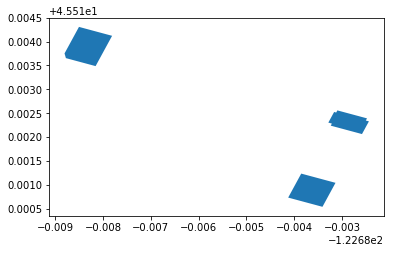

In [11]:
parking.plot()

In [12]:
import overpy
api = overpy.Overpass()
result = api.query("""(way["amenity"="parking"]["parking"="multi-storey"]["operator"="Portland State University"](45.378437479737,-122.7921295166,45.627484212338,-122.42992401123);way(354681069););out;""")
len(result.ways)

4

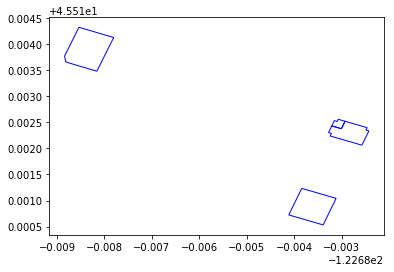

In [13]:
from shapely.geometry.polygon import Polygon
def create_polygon(way):
    coordinates=[]
    for n in way.nodes:
        node = next(x for x in result.nodes if x.id == n.id)
        coordinates.append((node.lon, node.lat))
    return Polygon(coordinates)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)

from descartes.patch import PolygonPatch

for way in result.ways:
    way.get_nodes(resolve_missing=True)
    polygon = create_polygon(way)
    patch = PolygonPatch(polygon, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(patch)
    
plt.axis("auto")
plt.show()

In [14]:
# This function converts a OpenStreetMap node into a GeoJSON Feature
def nodeToCoordinates(node):
    return [float(node.lon), float(node.lat)]

coord_convert = lambda coords: [coords[0], coords[1]]

def shapelyPolygonToFeature(polygon):
    coords = []
    for coord in polygon.exterior.coords:
        coords.append(coord_convert(coord))
        
    return {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": coords
        },
        "properties": {}
    }

# This function converts a collection of OpenStreetMap nodes into an array of
# GeoJSON Features
def nodesToFeatures(nodes):
    """
    :param nodes
    :type nodes from overpy.Result (result.nodes)
    :return:
    """
    features = []
    for node in nodes:
        features.append(nodeToFeature(node))
    return features

In [15]:
features =[]
for way in result.ways:
    polygon = create_polygon(way)
    features.append(shapelyPolygonToFeature(polygon))
    
geojson = {
    "type": "FeatureCollection",
    "features": features
}
import json
with open("data/psu_parking_structures.json", 'w+', encoding='utf-8') as f:
    f.write(json.dumps(geojson, ensure_ascii= False))
    f.close()